In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 536.2/536.2 kB 8.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 GB 16.8 MB/s eta 0:02:34
   ---------------------------------------- 0.0/2.6 GB 17.4 MB/s eta 0:02:28
   ---------------------------------------- 0.0/2.6 GB 16.8 MB/s eta 0:02:34
   ---------------------------------------- 0.0/2.6 GB 18.0 MB/s eta 0:02:23
   ---------------------------------------- 0.0/2.6 GB 18.0 MB/s eta 0:02:23
   ---------------------------------------- 0.0/2.6 GB 17.8 MB/s eta 0:02:24
   ---------------------------------------- 0.0/2.6 GB 18.2 MB/s eta 0:02:21
   ---------------------------------------- 0.0/2.6 GB 18.2 MB/s eta 0:02:2

In [2]:
!pip install scikit-learn pandas matplotlib seaborn jupyterlab

  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.0-cp312-cp312-win_amd64.whl.metadata (115 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached httpx-0.28.1-p

In [3]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
# Generate dataset
X, y = make_moons(n_samples=10000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

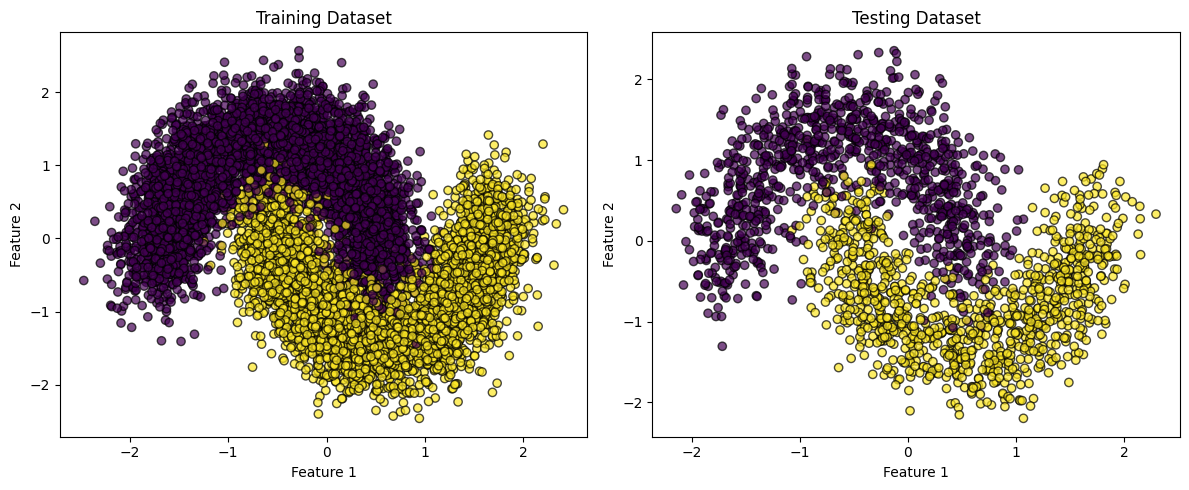

In [31]:
# Plot training and testing datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training data
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train.squeeze(), cmap='viridis', edgecolors='k', alpha=0.7)
ax1.set_title('Training Dataset')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Plot testing data
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test.squeeze(), cmap='viridis', edgecolors='k', alpha=0.7)
ax2.set_title('Testing Dataset')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [ ]:
class SimpleMLP:
    """
    A simple Multi-Layer Perceptron (MLP) neural network with one hidden layer.
    
    This implementation uses manual backpropagation to update weights and biases,
    demonstrating the fundamental mechanics of neural network training without
    relying on automatic differentiation frameworks.
    
    Architecture:
        Input Layer -> Hidden Layer (sigmoid) -> Output Layer (sigmoid)
    
    Attributes:
        W1 (torch.Tensor): Weight matrix for input to hidden layer (input_size x hidden_size)
        b1 (torch.Tensor): Bias vector for hidden layer (1 x hidden_size)
        W2 (torch.Tensor): Weight matrix for hidden to output layer (hidden_size x output_size)
        b2 (torch.Tensor): Bias vector for output layer (1 x output_size)
        z1 (torch.Tensor): Pre-activation values for hidden layer
        a1 (torch.Tensor): Activated values for hidden layer
        z2 (torch.Tensor): Pre-activation values for output layer
        a2 (torch.Tensor): Activated values for output layer (final predictions)
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the MLP with random weights and biases.
        
        Args:
            input_size (int): Number of input features
            hidden_size (int): Number of neurons in the hidden layer
            output_size (int): Number of output neurons (typically 1 for binary classification)
        """
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True)
        self.b1 = torch.randn(1, hidden_size, requires_grad=True)
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True)
        self.b2 = torch.randn(1, output_size, requires_grad=True)
    
    def forward(self, X):
        """
        Perform a forward pass through the network.
        
        This method computes the network's predictions by:
        1. Computing hidden layer pre-activations: z1 = X @ W1 + b1
        2. Applying sigmoid activation: a1 = sigmoid(z1)
        3. Computing output layer pre-activations: z2 = a1 @ W2 + b2
        4. Applying sigmoid activation: a2 = sigmoid(z2)
        
        Args:
            X (torch.Tensor): Input data of shape (batch_size, input_size)
        
        Returns:
            torch.Tensor: Network predictions of shape (batch_size, output_size)
                         Values are in range [0, 1] due to sigmoid activation
        """
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.a1 = torch.sigmoid(self.z1)  # Hidden layer activation
        self.z2 = torch.matmul(self.a1, self.W2) + self.b2
        self.a2 = torch.sigmoid(self.z2)  # Output layer activation
        return self.a2

    def backward(self, X, y, output, lr=0.01):
        """
        Perform backpropagation to compute gradients and update weights.
        
        This method implements the backpropagation algorithm manually:
        1. Computes gradients for output layer (dW2, db2)
        2. Propagates error back to hidden layer
        3. Computes gradients for hidden layer (dW1, db1)
        4. Updates all weights and biases using gradient descent
        
        The gradient calculations assume Mean Squared Error (MSE) loss and
        sigmoid activations throughout the network.
        
        Args:
            X (torch.Tensor): Input data of shape (batch_size, input_size)
            y (torch.Tensor): True labels of shape (batch_size, output_size)
            output (torch.Tensor): Network predictions from forward pass
            lr (float): Learning rate for gradient descent (default: 0.01)
        """
        m = X.shape[0]
        
        # Output layer gradients
        dz2 = output - y  # Gradient of MSE loss w.r.t. output
        dW2 = torch.matmul(self.a1.T, dz2)
        db2 = torch.sum(dz2, axis=0) / m

        # Hidden layer gradients
        da1 = torch.matmul(dz2, self.W2.T)
        dz1 = da1 * (self.a1 * (1 - self.a1))  # Sigmoid derivative
        dw1 = torch.matmul(X.T, dz1) / m
        db1 = torch.sum(dz1, axis=0) / m
        
        # Update weights using gradient descent
        with torch.no_grad():
            self.W1 -= lr * dw1
            self.b1 -= lr * db1
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
    def train(self, X, y, epochs=1000, lr=0.01):
        """
        Train the neural network using gradient descent.
        
        This method performs the complete training loop:
        1. Forward pass to compute predictions
        2. Calculate Mean Squared Error (MSE) loss
        3. Backward pass to update weights
        4. Track and print loss at regular intervals
        
        Args:
            X (torch.Tensor): Training input data of shape (batch_size, input_size)
            y (torch.Tensor): Training labels of shape (batch_size, output_size)
            epochs (int): Number of training iterations (default: 1000)
            lr (float): Learning rate for gradient descent (default: 0.01)
        
        Returns:
            list: Loss values for each epoch, useful for plotting training progress
        """
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            # Compute loss using Mean Squared Error (MSE)
            loss = torch.mean((output - y) ** 2)
            losses.append(loss.item())
            # Update weights
            self.backward(X, y, output, lr)
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        return losses

In [33]:
input_size = 2
hidden_size = 4
output_size = 1
model = SimpleMLP(input_size, hidden_size, output_size)

#Train  model and store the losses
losses = model.train(X_train, y_train, epochs=50000, lr=0.1)

Epoch [1000/50000], Loss: 0.0789
Epoch [2000/50000], Loss: 0.0562
Epoch [3000/50000], Loss: 0.0312
Epoch [4000/50000], Loss: 0.0231
Epoch [5000/50000], Loss: 0.0226
Epoch [6000/50000], Loss: 0.0222
Epoch [7000/50000], Loss: 0.0219
Epoch [8000/50000], Loss: 0.0217
Epoch [9000/50000], Loss: 0.0216
Epoch [10000/50000], Loss: 0.0216
Epoch [11000/50000], Loss: 0.0215
Epoch [12000/50000], Loss: 0.0214
Epoch [13000/50000], Loss: 0.0214
Epoch [14000/50000], Loss: 0.0214
Epoch [15000/50000], Loss: 0.0214
Epoch [16000/50000], Loss: 0.0214
Epoch [17000/50000], Loss: 0.0213
Epoch [18000/50000], Loss: 0.0213
Epoch [19000/50000], Loss: 0.0213
Epoch [20000/50000], Loss: 0.0213
Epoch [21000/50000], Loss: 0.0213
Epoch [22000/50000], Loss: 0.0213
Epoch [23000/50000], Loss: 0.0213
Epoch [24000/50000], Loss: 0.0213
Epoch [25000/50000], Loss: 0.0213
Epoch [26000/50000], Loss: 0.0213
Epoch [27000/50000], Loss: 0.0213
Epoch [28000/50000], Loss: 0.0213
Epoch [29000/50000], Loss: 0.0213
Epoch [30000/50000], Lo

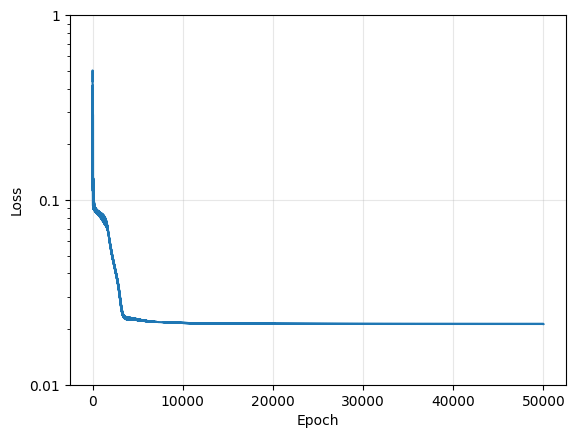

In [34]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.yticks([ 0.01, 0.1, 1], ['0.01', '0.1', '1',])
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
with torch.no_grad():
    test_output = model.forward(X_test)
    test_output = (test_output > 0.5).float() 
accuracy = torch.mean((test_output == y_test).float())
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Accuracy: 97.10%


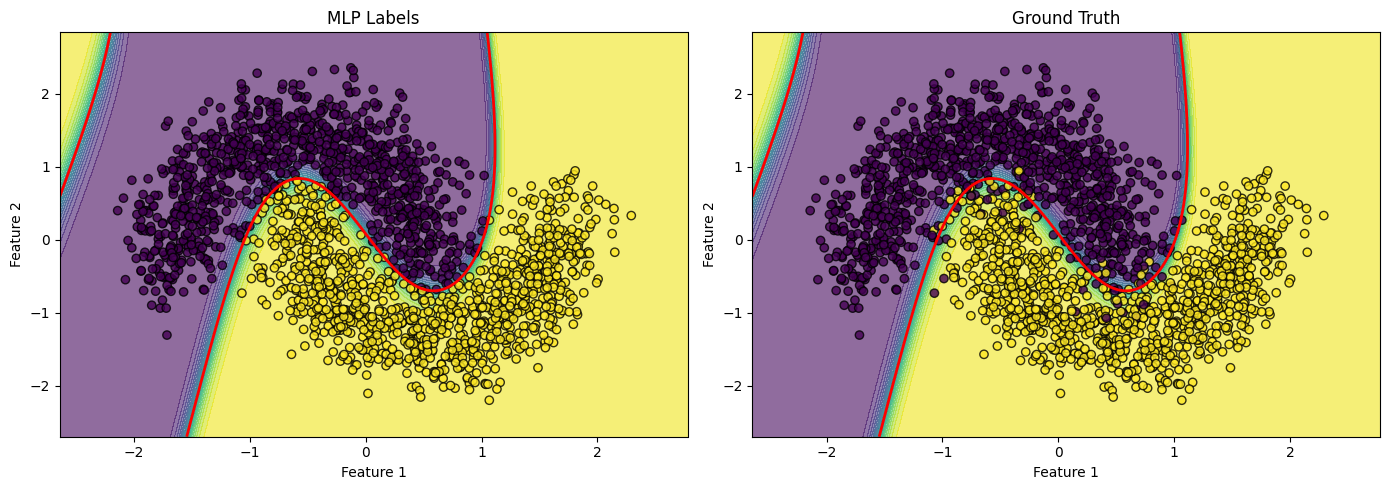

In [38]:
# Create a mesh grid for decision boundary
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
h = 0.02
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing='ij')

# Predict on the mesh grid
grid_points = torch.stack([xx.ravel(), yy.ravel()], dim=1)
with torch.no_grad():
    Z = model.forward(grid_points)
    Z = Z.reshape(xx.shape)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left subplot: MLP classified labels
ax1.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.6)
ax1.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)
ax1.scatter(X_test[:, 0], X_test[:, 1], c=test_output.squeeze(), cmap='viridis', edgecolors='k', alpha=0.8)
ax1.set_title('MLP Labels')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Right subplot: Ground truth labels
ax2.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.6)
ax2.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test.squeeze(), cmap='viridis', edgecolors='k', alpha=0.8)
ax2.set_title('Ground Truth')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()